<a href="https://colab.research.google.com/github/YIye-Lin/Cloud-Detection/blob/main/Using_lRlS%2C_Convolutional_Neural_Networks_(CNN)_and_Random_Forests_for_Cloud_Detection_in_United_Kingdom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using lRlS, Convolutional Neural Networks (CNN) and Random Forests for Cloud Detection in United Kingdom.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creating Chunks for IRIS


In [ ]:
!pip install netCDF4

In [ ]:
import os
import netCDF4
import numpy as np
import re

# Define the path to the main folder where your data is stored.
# You need to replace 'path/to/data' with the actual path to your data folder.
main_folder_path = '/content/drive/MyDrive/GEOL0069'

# This part of the code is responsible for finding all directories in the main_folder that end with '.SEN3'.
# '.SEN3' is the format of the folder containing specific satellite data files (in this case, OLCI data files).
directories = [d for d in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, d)) and d.endswith('.SEN3')]

# Loop over each directory (i.e., each set of data) found above.
for directory in directories:
    # Construct the path to the OLCI data file within the directory.
    # This path is used to access the data files.
    OLCI_file_p = os.path.join(main_folder_path, directory)

    # Print the path to the current data file being processed.
    # This is helpful for tracking which file is being processed at any time.
    print(f"Processing: {OLCI_file_p}")

    # Load the instrument data from a file named 'instrument_data.nc' inside the directory.
    # This file contains various data about the instrument that captured the satellite data.
    instrument_data = netCDF4.Dataset(OLCI_file_p + '/instrument_data.nc')
    solar_flux = instrument_data.variables['solar_flux'][:]  # Extract the solar flux data.
    detector_index = instrument_data.variables['detector_index'][:]  # Extract the detector index.

    # Load tie geometries from a file named 'tie_geometries.nc'.
    # Tie geometries contain information about viewing angles, which are important for data analysis.
    tie_geometries = netCDF4.Dataset(OLCI_file_p + '/tie_geometries.nc')
    SZA = tie_geometries.variables['SZA'][:]  # Extract the Solar Zenith Angle (SZA).

    # Create a directory for saving the processed data using the original directory name.
    # This directory will be used to store output files.
    save_directory = os.path.join('/content/drive/MyDrive/GEOL0069')
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # This loop processes each radiance band in the OLCI data.
    # OLCI instruments capture multiple bands, each representing different wavelengths.
    OLCI_data = []
    for Radiance in range(1, 22):  # There are 21 bands in OLCI data.

        Rstr = "%02d" % Radiance  # Formatting the band number.
        solar_flux_band = solar_flux[Radiance - 1]  # Get the solar flux for the current band.

        # Print information about the current band being processed.
        # This includes the band number and its corresponding solar flux.
        print(f"Processing Band: {Rstr}")
        print(f"Solar Flux for Band {Rstr}: {solar_flux_band}")

        # Load radiance values from the OLCI data file for the current band.
        OLCI_nc = netCDF4.Dataset(OLCI_file_p + '/Oa' + Rstr + '_radiance.nc')
        radiance_values = np.asarray(OLCI_nc['Oa' + Rstr + '_radiance'])

        # Initialize an array to store angle data, which will be calculated based on SZA.
        angle = np.zeros_like(radiance_values)
        for x in range(angle.shape[1]):
            angle[:, x] = SZA[:, int(x/64)]

        # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF) for the current band.
        TOA_BRF = (np.pi * radiance_values) / (solar_flux_band[detector_index] * np.cos(np.radians(angle)))

        # Add the calculated TOA BRF data to the OLCI_data list.
        OLCI_data.append(TOA_BRF)

        # Print the range of reflectance values for the current band.
        print(f"Reflectance Values Range for Band {Rstr}: {np.nanmin(TOA_BRF)}, {np.nanmax(TOA_BRF)}")

    # Reshape the OLCI_data array for further analysis or visualization.
    reshaped_array = np.moveaxis(np.array(OLCI_data), 0, -1)
    print("Reshaped array shape:", reshaped_array.shape)

    # Split the reshaped array into smaller chunks along the second dimension.
    # This can be useful for handling large datasets more efficiently.
    split_arrays = np.array_split(reshaped_array, 5, axis=1)

    # Save each chunk of data separately.
    # This is helpful for processing or analyzing smaller portions of data at a time.
    for i, arr in enumerate(split_arrays):
        print(f"Chunk {i+1} shape:", arr.shape)
        save_path = os.path.join(save_directory, f"chunk_{i+1}_band_{Rstr}.npy")
        np.save(save_path, arr)
        print(f"Saved Chunk {i+1} for Band {Rstr} to {save_path}")

Processing: /content/drive/MyDrive/GEOL0069/S3A_OL_1_EFR____20230621T105847_20230621T110147_20230622T120215_0180_100_151_1980_PS1_O_NT_003.SEN3
Processing Band: 01
Solar Flux for Band 01: [1472.3195 1472.284  1472.2488 ... 1466.1184 1466.0935 1466.0687]
Reflectance Values Range for Band 01: 0.13027161359786987, 199.14962768554688
Processing Band: 02
Solar Flux for Band 02: [1655.8489 1655.8408 1655.8329 ... 1652.6277 1652.6204 1652.6129]
Reflectance Values Range for Band 02: 0.11829124391078949, 176.6699676513672
Processing Band: 03
Solar Flux for Band 03: [1838.063  1838.0315 1837.9999 ... 1826.8164 1826.7958 1826.775 ]
Reflectance Values Range for Band 03: 0.09119772911071777, 159.82650756835938
Processing Band: 04
Solar Flux for Band 04: [1879.5143 1879.4945 1879.475  ... 1871.9451 1871.9347 1871.9246]
Reflectance Values Range for Band 04: 0.06350262463092804, 155.9716033935547
Processing Band: 05
Solar Flux for Band 05: [1853.7549 1853.7743 1853.7937 ... 1860.761  1860.7723 1860.78

## Create the dataset from IRIS

In [1]:
# Import all packages needed
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Specify your path to files
path = '/content/drive/MyDrive/GEOL0069/S3A_OL_1_EFR____20230621T105847_20230621T110147_20230622T120215_0180_100_151_1980_PS1_O_NT_003.SEN3'
directory = '/chunk_3_band_21.npy'
datadir = path+directory

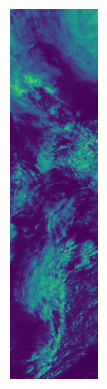

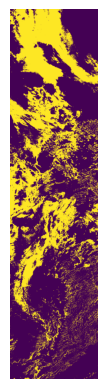

(4090, 973)
(4090, 973, 21)
(3969448, 3, 3, 21)
(3969448,)
{np.int64(0): np.int64(2645108), np.int64(1): np.int64(1324340)}
{np.int64(0): np.int64(8958), np.int64(1): np.int64(1191854)}


In [3]:
# The images are in numpy array format
image = np.load(datadir)

# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [0,0,973,4090]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]
# Now also read in the mask file
mask = cv2.imread('/content/drive/MyDrive/GEOL0069/mask.png', cv2.IMREAD_UNCHANGED)


# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
# binary_mask = np.where(mask[:,:,0] == 0, 1, 0)
binary_mask = np.where(mask[:,:,2] == 0, 1, 0)
# Extract channels 1, 2, and 3
channel_1 = roi[:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# Plotting the RGB image and you will see if it corresponds to the mask
plt.imshow(rgb_image)
plt.axis('off')
plt.show()
# You can also plot the mask
plt.imshow(binary_mask)
plt.axis('off')
plt.show()
## Another check needs to be done is their shape in first two dimensions
print(binary_mask.shape)
print(roi.shape)
# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)
# Assuming patches_array is your X and labels is your y
x_train, x_test, y_train, y_test = train_test_split(patches_array, labels, test_size=0.1, random_state=42)
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 9896 # Adjust it to the amount you get
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

In [4]:
import numpy as np
np.save ('/content/drive/MyDrive/GEOL0069/X_train_balanced.npy',X_train_balanced)
np.save ('/content/drive/MyDrive/GEOL0069/X_test_balanced.npy',X_test_balanced)
np.save ('/content/drive/MyDrive/GEOL0069/y_train_balanced.npy',y_train_balanced)
np.save ('/content/drive/MyDrive/GEOL0069/y_test_balanced.npy',y_test_balanced)

## Loading the data

In [1]:
import os
import numpy as np

data_dir = '/content/drive/MyDrive/GEOL0069'
X_train = np.load(os.path.join(data_dir,'X_train_balanced.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(data_dir,'y_train_balanced.npy'))
y_test = np.load(os.path.join(data_dir,'y_test_balanced.npy'))

## Convolutional Neural Networks (CNN)##

Convolutional Neural Networks (CNNs) are a class of deep learning models particularly well-suited for image classification, object detection, and spatial data analysis. They are designed to automatically and adaptively learn spatial hierarchies of features from input images.

###  Key Components:
- **Convolutional layers**: Extract local features using learnable filters (kernels).
- **Pooling layers**: Reduce spatial dimensions, improve efficiency, and control overfitting.
- **Flattening**: Converts 2D feature maps into a 1D vector for classification.
- **Dense (Fully Connected) layers**: Perform final classification based on learned features.

CNNs are highly effective in processing multi-band remote sensing data, such as satellite images, by identifying spatial patterns (e.g., clouds, land cover types) based on spectral and spatial context.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(3, 3, 21), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes
model.add(layers.Dense(1, activation='sigmoid'))  # 1 neuron for binary classification


# Compile and train the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10,
        validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9946 - loss: 0.0281 - val_accuracy: 0.9974 - val_loss: 0.0112
Epoch 2/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9971 - loss: 0.0123 - val_accuracy: 0.9973 - val_loss: 0.0108
Epoch 3/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.9974 - loss: 0.0112 - val_accuracy: 0.9979 - val_loss: 0.0097
Epoch 4/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.9974 - loss: 0.0107 - val_accuracy: 0.9968 - val_loss: 0.0129
Epoch 5/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.9976 - loss: 0.0103 - val_accuracy: 0.9976 - val_loss: 0.0093
Epoch 6/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.9977 - loss: 0.0099 - val_accuracy: 0.9977 - val_loss: 0.0091
Epoch 7/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.9977 - loss: 0.0096 - val_accuracy: 0.9981 - val_loss: 0.0090
Epoch 8/10
33773/33773 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 

In [3]:
# Save the trained model
model.save('/content/drive/MyDrive/GEOL0069/modelCNN.h5')  # Save as HDF5 file

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/GEOL0069/modelCNN.h5')


Loss and accuracy curve

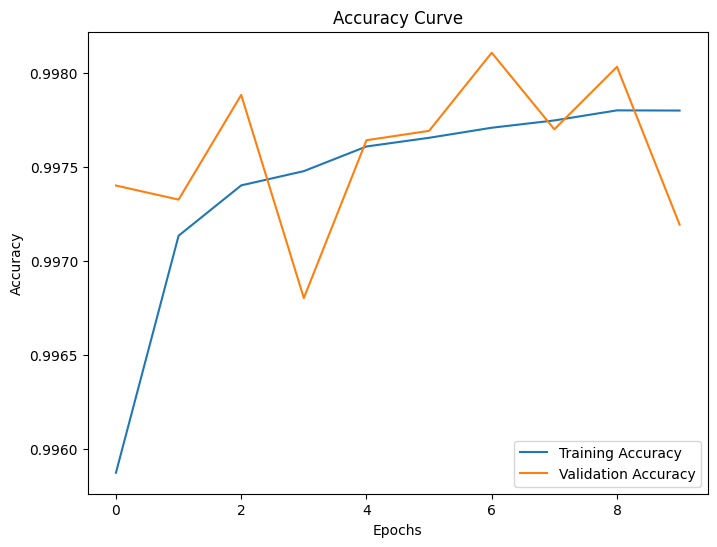

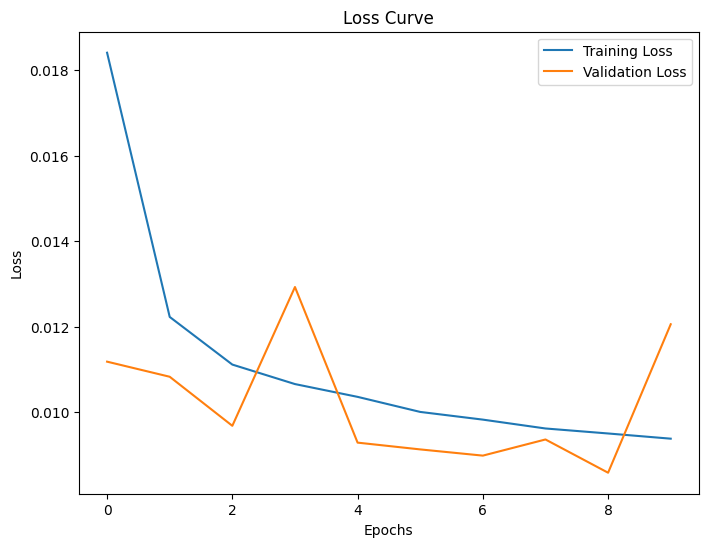

In [4]:
import matplotlib.pyplot as plt


# Plot the loss and accuracy curves
def plot_training_curves(history):
    # Extract values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Call the function to plot the curves
plot_training_curves(history)


Calculation of confusion matrix.

4170/4170 ━━━━━━━━━━━━━━━━━━━━ 4s 942us/step


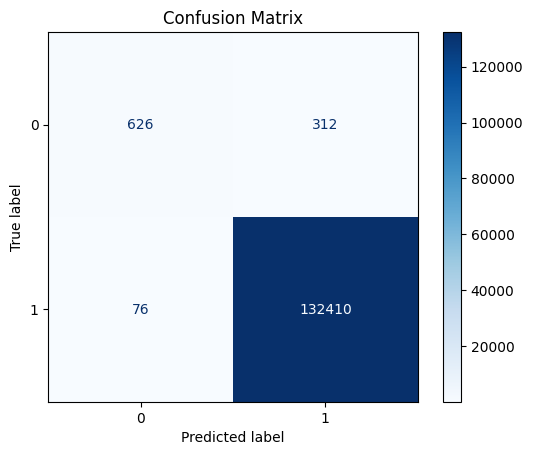

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
# y_pred_classes = y_pred.argmax()  # Convert probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Use the unique class labels from y_test
unique_labels = sorted(set(y_test))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


## Apply the model to generate a complete image for cloud detection (CNN):##

In [6]:
import tensorflow as tf
# Load in trained CNN model
# cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/GEOL0069/2425/Week 2/Week2_AI_Algorithms/modelCNN.h5')
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/GEOL0069/modelCNN.h5')


In [8]:
import numpy as np
# The images are in numpy array format
# image = np.load('/content/drive/MyDrive/GEOL0069/2425/Week 3/chunk_3_band_21.npy')
image = np.load('/content/drive/MyDrive/GEOL0069/chunk_3_band_21.npy')


# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [0, 0, 973, 4090]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]

# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array ---this is for all the NN approach rollout
x_test_all = np.array(patches)
model1 = cnn_model # You can change this to vit_model
y_pred=model1.predict(x_test_all, batch_size = 250)
y_pred1 = (y_pred > 0.5).astype(int)
map1 = y_pred1.reshape(roi.shape[0]-2, roi.shape[1]-2)


15878/15878 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


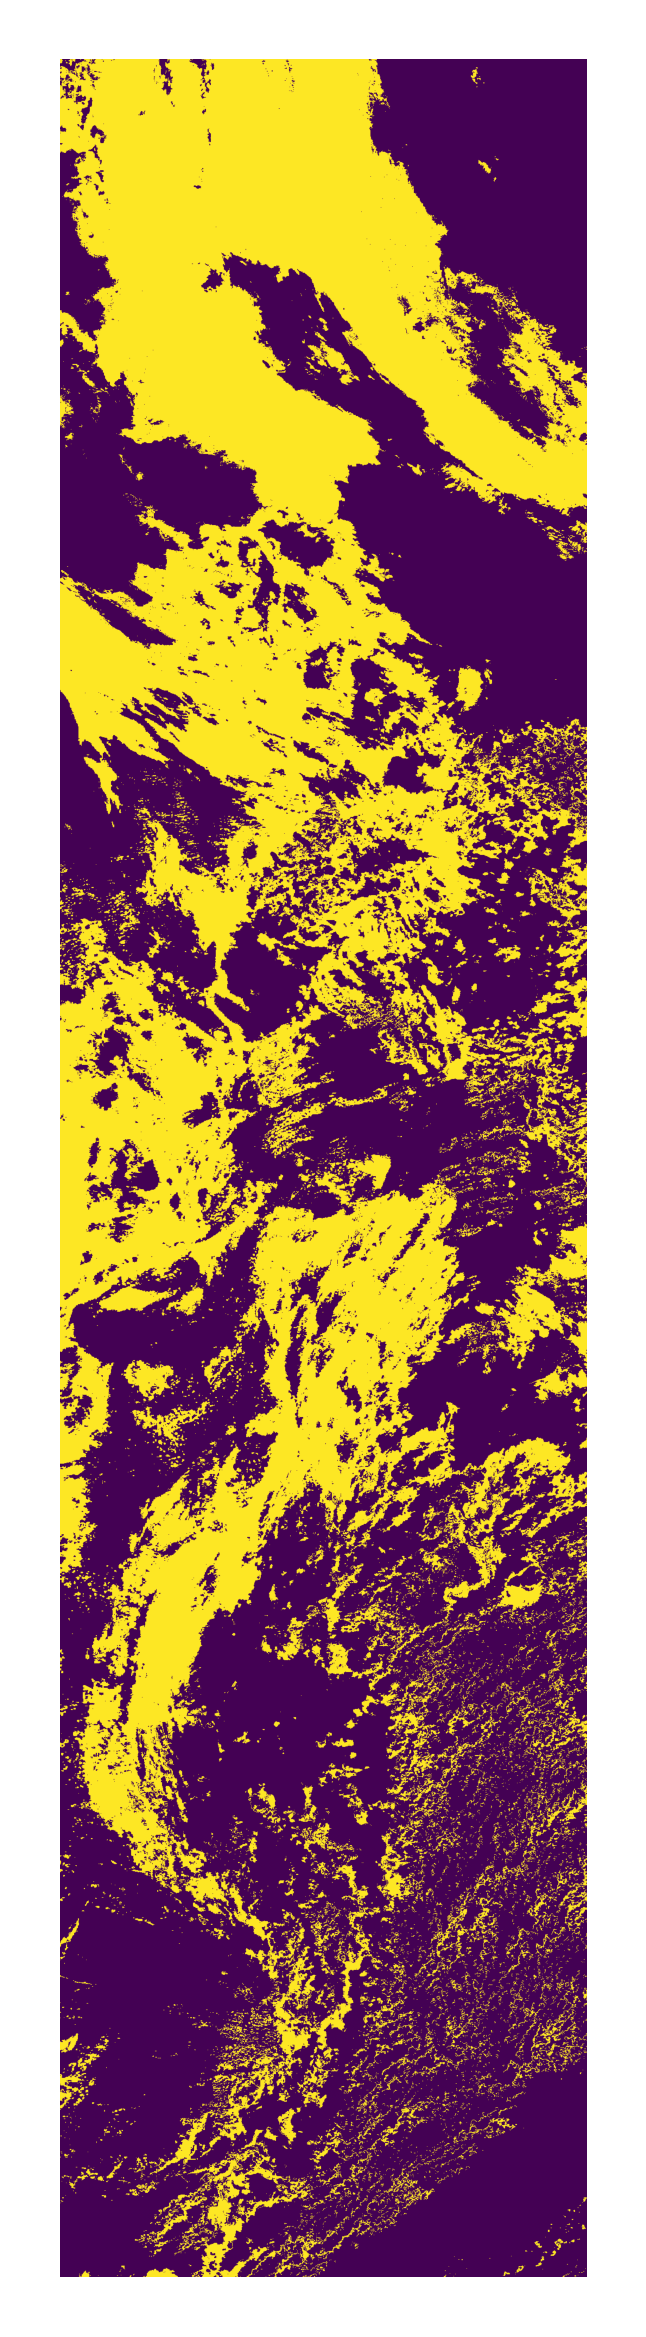

In [20]:
# Display the results
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map1)
save_dir = '/content/drive/MyDrive/GEOL0069/CNN_image'
plt.axis('off')  # Remove axis for a cleaner image
plt.savefig(save_dir, dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


## Random Forests (RF)

Random Forest is a powerful ensemble learning algorithm that combines the predictions of multiple decision trees to improve accuracy and robustness. It is widely used for classification and regression tasks, especially when working with structured/tabular data.

### Key Concepts:
- **Ensemble of decision trees**: Each tree is trained on a random subset of the data and features.
- **Voting/Averaging**: Predictions are aggregated across trees (majority vote for classification).
- **Robust to overfitting**: Due to randomness and ensemble averaging.
- **Nonlinear modeling**: Can capture complex patterns without needing scaling or normalization.

In remote sensing, RF is often used for land cover classification, cloud detection, and other image-based tasks thanks to its efficiency, interpretability, and accuracy on high-dimensional data.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialise the model with n_estimators specifying the number of trees in the forest
clf = RandomForestClassifier(n_estimators=100)

# We need to reshape the data in order to be compatible with Random Forest
X_reshaped = np.reshape(X_train, (X_train.shape[0], -1))
# Fit the model to your training data
clf.fit(X_reshaped, y_train)

# Predict the classes of the test data
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], -1))
y_pred = clf.predict(X_test_reshaped)

Calculation of confusion matrix.

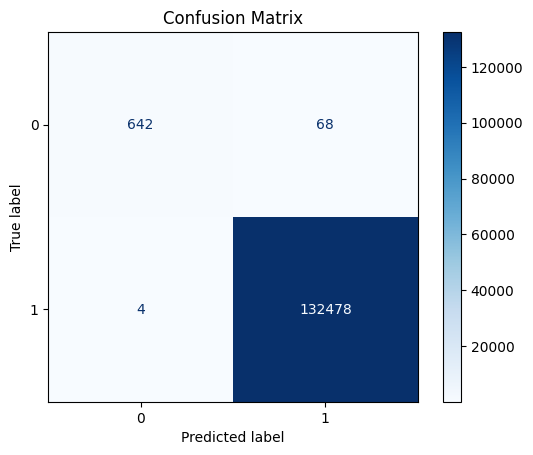

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_test)))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import joblib

# Specify the directory and file name where you want to save the model
file_path = '/content/drive/MyDrive/GEOL0069/random_forest_model.pkl'

# Save the model to the specified path
joblib.dump(clf, file_path)
print(f"Model saved at: {file_path}")

Model saved at: /content/drive/MyDrive/GEOL0069/random_forest_model.pkl


In [ ]:
# Load the model from the file
loaded_model = joblib.load('/content/drive/MyDrive/GEOL0069/random_forest_model.pkl')
print("Model loaded successfully.")

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test_reshaped)


Model loaded successfully.


## Apply the model to generate a complete image for cloud detection (RF):##

In [10]:
import joblib

# Load the model from the file
rf_model = joblib.load('//content/drive/MyDrive/GEOL0069/random_forest_model.pkl')
print("Model loaded successfully.")


Model loaded successfully.


In [11]:
# For random forest rollout

X_test_reshaped = np.reshape(x_test_all, (x_test_all.shape[0], -1))
y_pred_loaded = rf_model.predict(X_test_reshaped)
map1=y_pred_loaded.reshape(roi.shape[0]-2, roi.shape[1]-2)

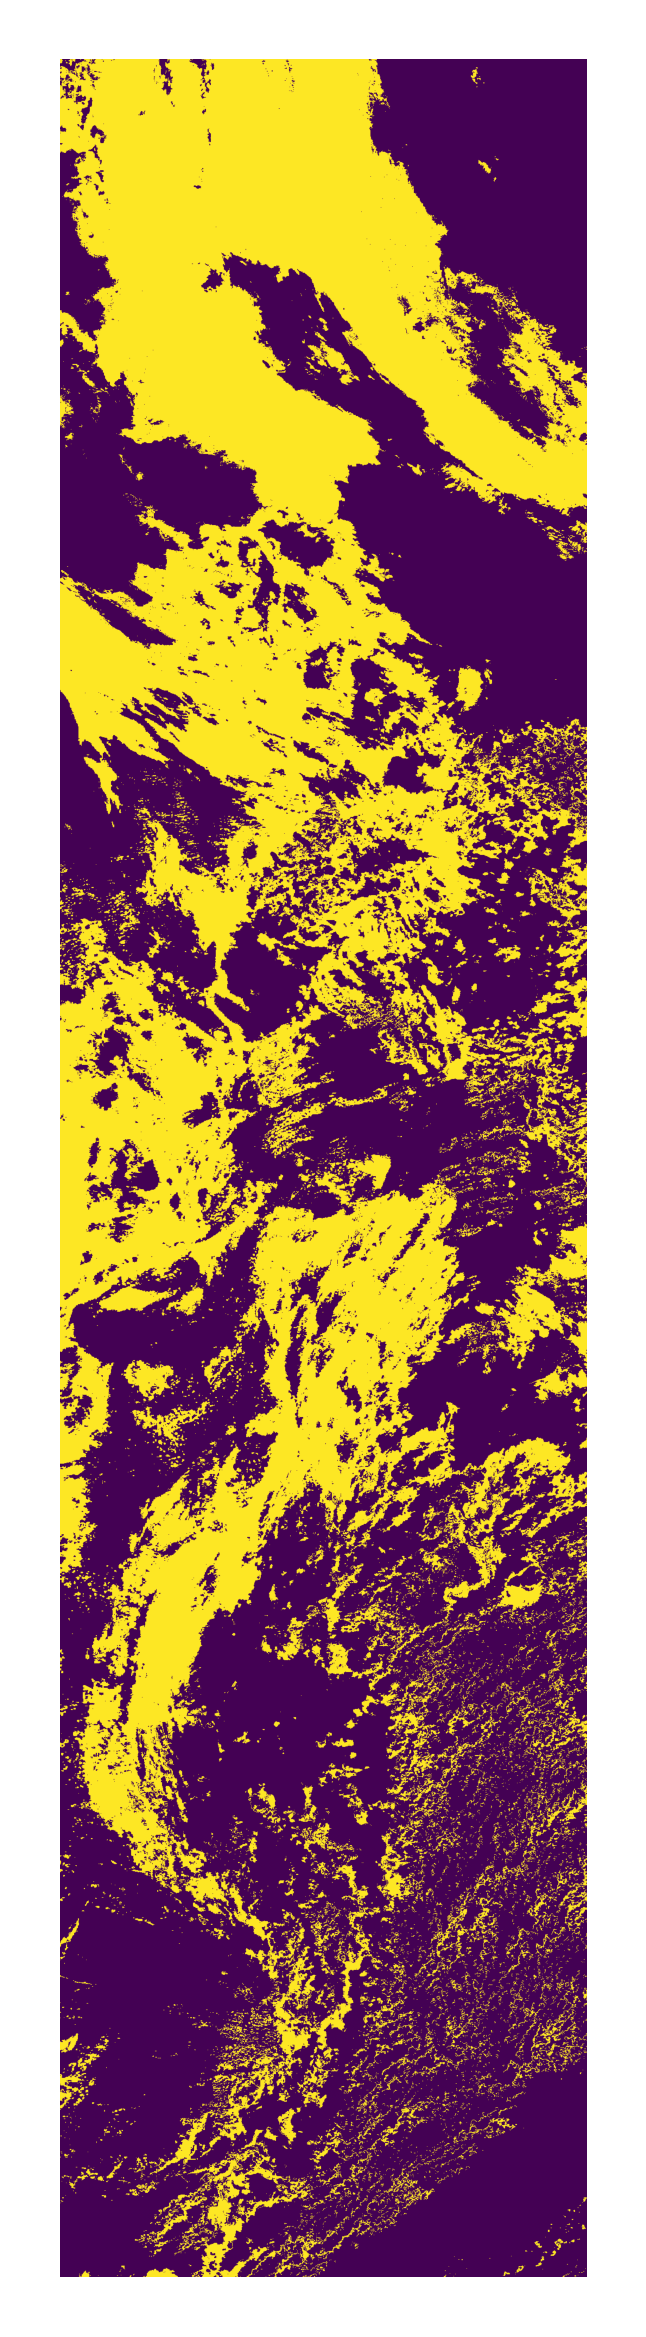

In [21]:
# Alter the view setting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map1)
save_dir = '/content/drive/MyDrive/GEOL0069/RF_image'
plt.axis('off')  # Remove axis for a cleaner image
plt.savefig(save_dir, dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

##  Conclusion: CNN vs. Random Forest for Cloud Classification

### CNN (Convolutional Neural Network)
- Produces smoother and more spatially coherent cloud masks.
- Captures cloud boundaries more accurately.
- Fewer misclassifications observed.

###  Random Forest (RF)
- Simpler and faster to train.
- Results appear noisier with more scattered predictions.
- Higher number of misclassified pixels, especially in clear-sky regions.


CNN demonstrates superior performance in both visual quality and classification accuracy. For cloud detection tasks using multi-band remote sensing data, CNN is the preferred approach over Random Forest.
